# Forecasting with Temporian and TensorFlow Decision Forests

## Install and import dependencies


In [ ]:
%pip install temporian -q

# The Bokeh package is used by Temporian to create interactive plots.
# If if Bokeh is not installed, Temporian plots are static.
%pip install bokeh -q

In [1]:
import os
import pandas as pd
import temporian as tp
import datetime
import concurrent.futures

In [2]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 4, 30)
#end_date = datetime.date(2018, 9, 30)

filenames = []
while start_date <= end_date:
    filenames.append(f"{start_date}")
    start_date += datetime.timedelta(days=1)
print(f"{len(filenames)} dates")

30 dates


In [3]:
def load_date(filename):
    print(".",end="", flush=True)
    return pd.read_pickle(f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/main/data/{filename}.pkl")

print("Loading dataset",end="")
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    frames = executor.map(load_date, filenames)
pandas_dataset = pd.concat(frames)
print("done")
print(f"Found {len(pandas_dataset)} transactions")

Loading dataset..............................done
Found 288062 transactions


In [4]:
pandas_dataset

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
288057,288057,2018-04-30 23:56:58,818,7690,48.92,2591818,29,0,0
288058,288058,2018-04-30 23:57:38,3763,7460,99.06,2591858,29,0,0
288059,288059,2018-04-30 23:57:39,2000,8998,83.24,2591859,29,0,0
288060,288060,2018-04-30 23:58:01,2566,6688,109.55,2591881,29,0,0


In [5]:
pandas_dataset = pandas_dataset[["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]]

In [6]:
dataset = tp.from_pandas(pandas_dataset, timestamps="TX_DATETIME")

In [7]:
dataset

indexes: []
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
events:
     (288062 events):
        timestamps: [1.5225e+09 1.5225e+09 1.5225e+09 ... 1.5251e+09 1.5251e+09 1.5251e+09]
        'CUSTOMER_ID': ['596' '4961' '2' ... '2000' '2566' '1274']
        'TERMINAL_ID': ['3156' '3412' '1365' ... '8998' '6688' '4535']
        'TX_AMOUNT': [ 57.16  81.51 146.   ...  83.24 109.55  79.02]
        'TX_FRAUD': [0 0 0 ... 0 0 0]
memory usage: 16.1 MB

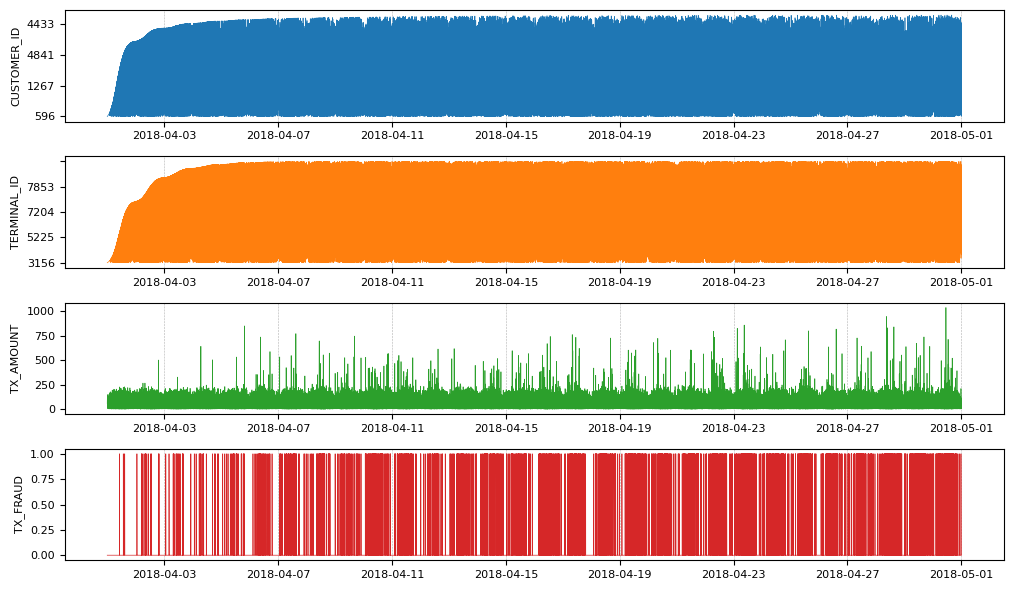

In [8]:
dataset.plot()

Build schedule
Run 1 operators
    1 / 1: ADD_INDEX [0.18649 s]
Execution in 0.18687 s


The number of plots (14877) is larger than "options.max_num_plots=4". Only the first plots will be printed.


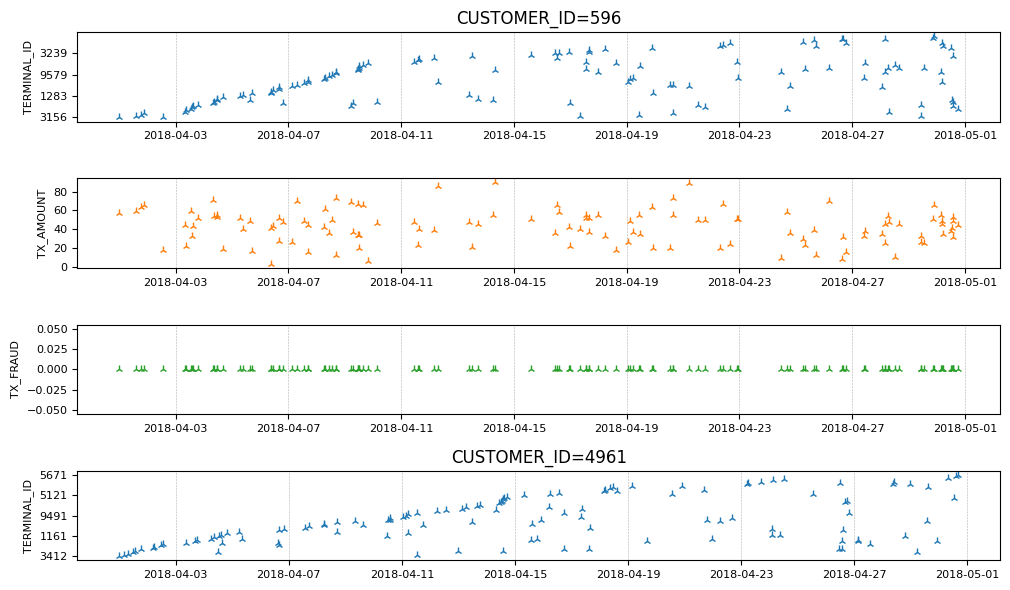

In [33]:
dataset_node = dataset.node()
#x = tp.filter(dataset_node, tp.equal(dataset_node["CUSTOMER_ID"], "596"))
x = tp.add_index(dataset_node, ["CUSTOMER_ID"])

x.evaluate(dataset).plot(max_num_plots=4)

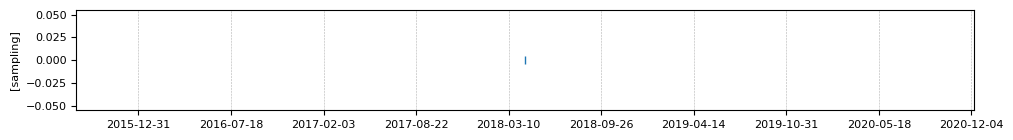

In [36]:
train_test_limit = tp.event_set(timestamps=["2018-04-15"])

train_test_limit.plot()

Build schedule
Run 3 operators
    1 / 3: SINCE_LAST [0.00083 s]
    2 / 3: IS_NAN [0.00048 s]
    3 / 3: FILTER [0.00188 s]
Execution in 0.00373 s


The number of plots (4) is larger than "options.max_num_plots=1". Only the first plots will be printed.


Build schedule
Run 4 operators
    1 / 4: SINCE_LAST [0.00037 s]
    2 / 4: IS_NAN [0.00024 s]
    3 / 4: INVERT [0.00005 s]
    4 / 4: FILTER [0.00110 s]
Execution in 0.00207 s


The number of plots (4) is larger than "options.max_num_plots=1". Only the first plots will be printed.


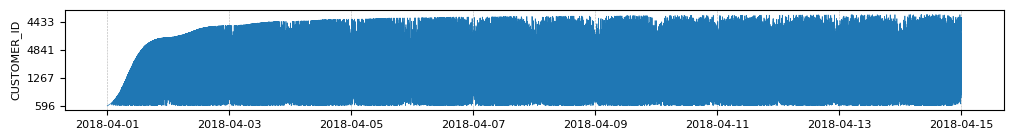

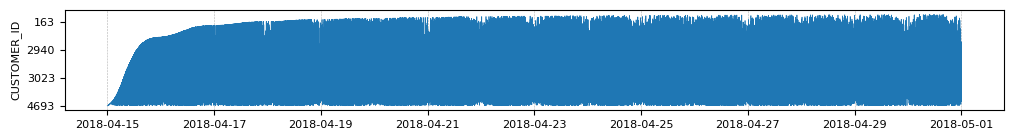

In [41]:
is_train_node = tp.isnan(tp.since_last(train_test_limit.node(), dataset_node))
is_test_node = tp.invert(is_train_node)

tp.filter(dataset_node, is_train_node).evaluate([dataset, train_test_limit]).plot(max_num_plots=1)
tp.filter(dataset_node, is_test_node).evaluate([dataset, train_test_limit]).plot(max_num_plots=1)

In [ ]:
# Per client, and per terminal
# sum and ratio of fraud over the last X  days.
# Delay of 1 week before the fraud information is available

Build schedule
Run 5 operators
    1 / 5: ADD_INDEX [0.21037 s]
    2 / 5: SELECT [0.02251 s]
    3 / 5: LAG [0.02579 s]
    4 / 5: CAST [0.10723 s]
    5 / 5: SIMPLE_MOVING_AVERAGE [0.04686 s]
Execution in 0.41359 s


The number of plots (10000) is larger than "options.max_num_plots=20". Only the first plots will be printed.


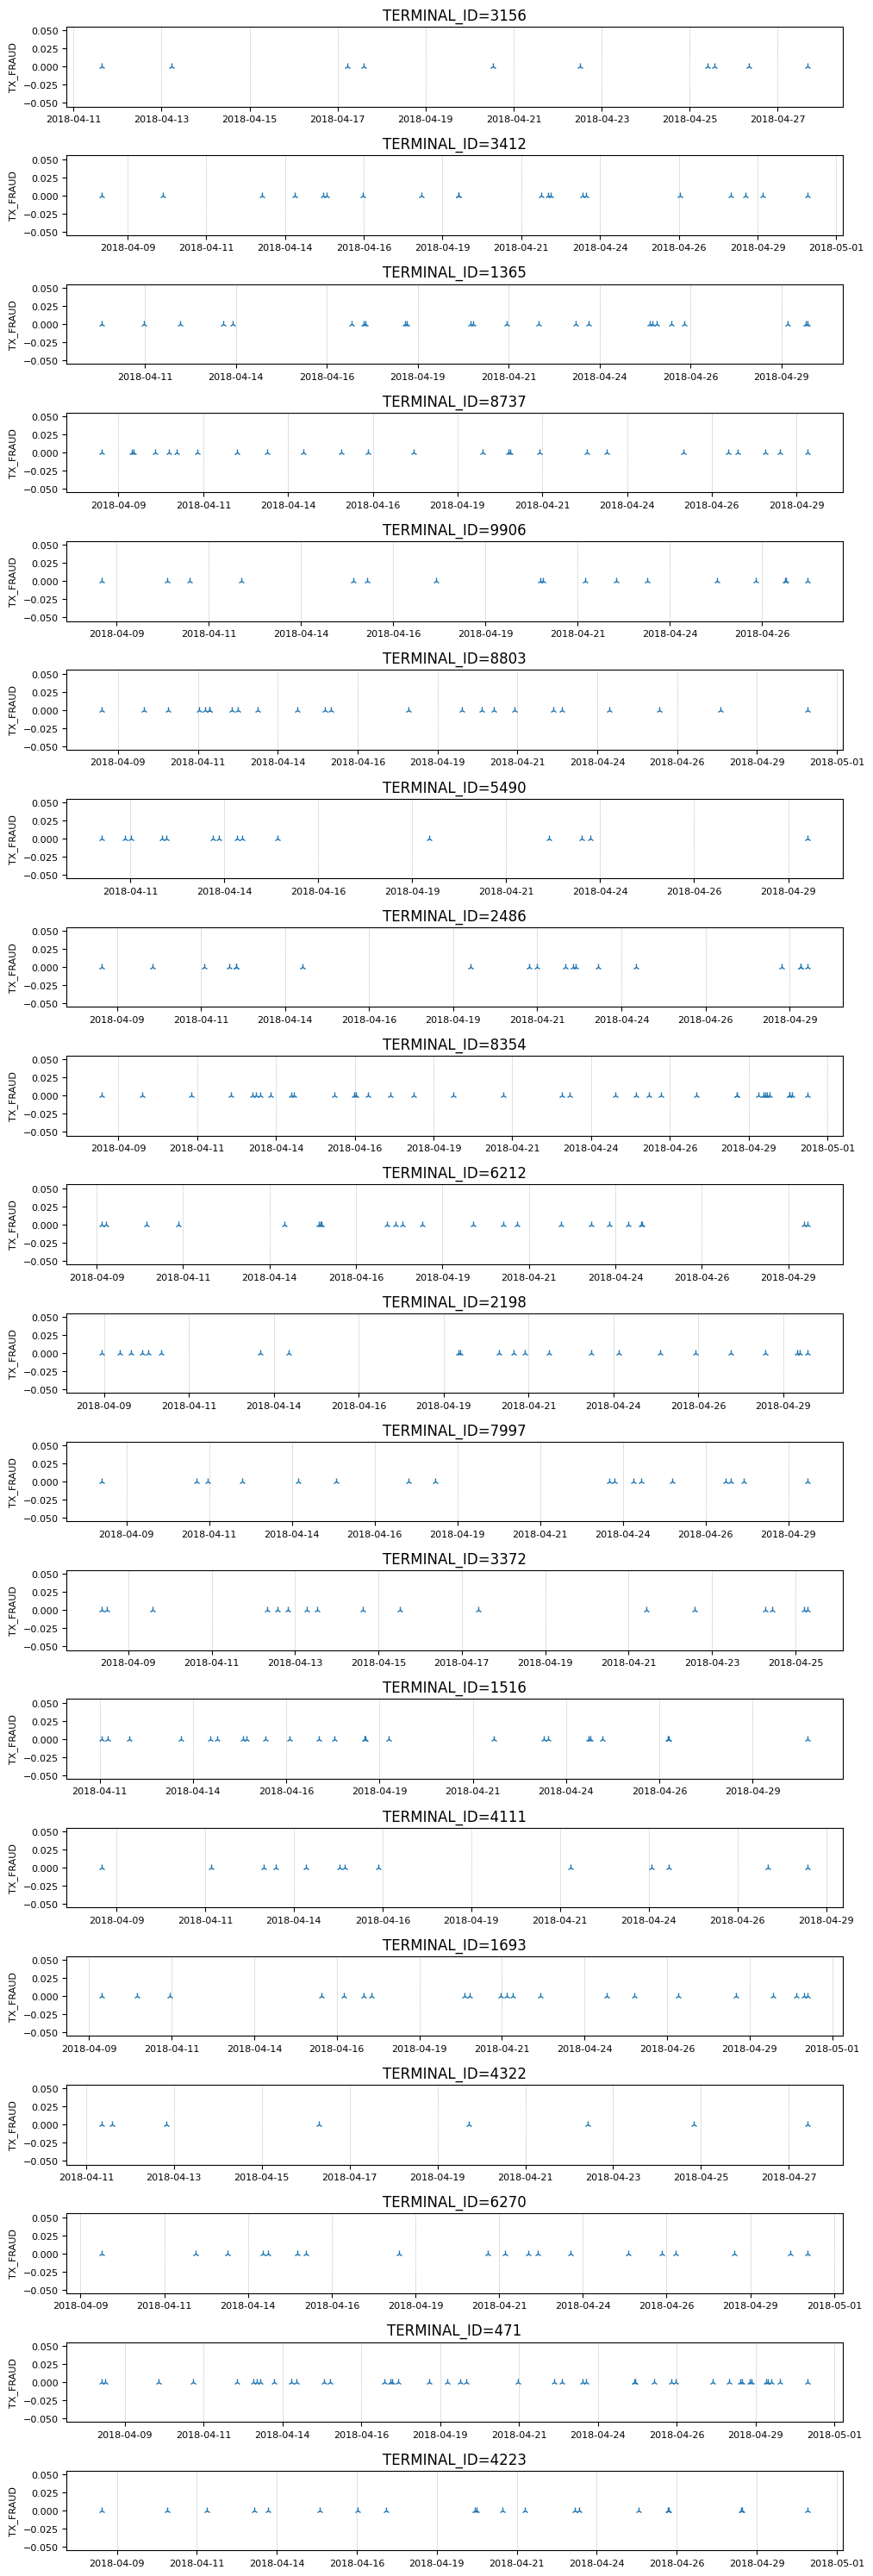

In [48]:
x = tp.add_index(dataset_node, "TERMINAL_ID")
fraud = tp.lag(x["TX_FRAUD"], tp.duration.weeks(1))
feature = tp.simple_moving_average(tp.cast(fraud, tp.float32), tp.duration.weeks(2), sampling=x)


feature.evaluate(dataset).plot()